In [69]:
import pandas as pd
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.sparse import csr_matrix 
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split


Pricilla Nakyazze



DATA 612 Project 4  - Accuracy and Beyond


This Data is from 24,938 users who have rated between 15 and 35 jokes, a matrix with dimensions 24,938 X 101

rows = 24,983 users columns = 100 jokes)

In [70]:
import pandas as pd
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.sparse import csr_matrix 
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split


In [71]:
file_path = r"C:\Users\pricc\OneDrive\Desktop\jester-data-1.csv"


In [72]:
df = pd.read_csv(file_path, header=None)

In [73]:
joke_matrix = df.to_numpy()
print("Shape:", df.shape, "(24982 users × 101 jokes)")



Shape: (24983, 101) (24982 users × 101 jokes)


In [74]:
# Assign column names: first column is 'ratingCount', then joke_1 to joke_100
df.columns = ['ratingCount'] + [f'joke_{i}' for i in range(1, 101)]

#Remove 'ratingCount' column
ratings = df.drop(columns=['ratingCount'])

#Replace 99 (unrated) with NaN
ratings.replace(99, np.nan, inplace=True)

#Select first 5000 users
ratings = ratings.iloc[:5000]

#Convert to NumPy matrix (if needed)
ratings_matrix = ratings.to_numpy()

# Convert to sparse matrix (CSR format)¶
ratings_sparse = csr_matrix(np.nan_to_num(ratings_matrix, nan=0.0))

In [75]:
#  Show original DataFrame we are converting
print("Original Jester ratings DataFrame (first 5 rows):")
print(ratings.head())
print("\n" + "="*60 + "\n")

# Convert to matrix
ratings_matrix = ratings.to_numpy()

# Print matrix summary
print("Converted Jester Ratings Matrix:")
print("Shape:", ratings.shape, "(users × jokes)")
print(ratings_matrix)

Original Jester ratings DataFrame (first 5 rows):
   joke_1  joke_2  joke_3  joke_4  joke_5  joke_6  joke_7  joke_8  joke_9  \
0   -7.82    8.79   -9.66   -8.16   -7.52   -8.50   -9.85    4.17   -8.98   
1    4.08   -0.29    6.36    4.37   -2.38   -9.66   -0.73   -5.34    8.88   
2     NaN     NaN     NaN     NaN    9.03    9.27    9.03    9.27     NaN   
3     NaN    8.35     NaN     NaN    1.80    8.16   -2.82    6.21     NaN   
4    8.50    4.61   -4.17   -5.39    1.36    1.60    7.04    4.61   -0.44   

   joke_10  ...  joke_91  joke_92  joke_93  joke_94  joke_95  joke_96  \
0    -4.76  ...     2.82      NaN      NaN      NaN      NaN      NaN   
1     9.22  ...     2.82    -4.95    -0.29     7.86    -0.19    -2.14   
2      NaN  ...      NaN      NaN      NaN     9.08      NaN      NaN   
3     1.84  ...      NaN      NaN      NaN     0.53      NaN      NaN   
4     5.73  ...     5.19     5.58     4.27     5.19     5.73     1.55   

   joke_97  joke_98  joke_99  joke_100  
0    -5

In [76]:
# Count number of non-NaN ratings per user (row)
joke_counts = ratings.notna().sum(axis=1)

# Display first few counts
print(joke_counts.head())

0     74
1    100
2     49
3     48
4     91
dtype: int64


In [77]:
# Calculate average rating for each joke (ignore NaNs)
joke_means = ratings.mean(axis=0)

# Find index of best joke (max average rating)
best_joke_index = joke_means.idxmax()

#Get the average rating of that joke
best_joke_rating = joke_means.max()

print(f"Best joke is {best_joke_index} with an average rating of {best_joke_rating:.2f}")

Best joke is joke_89 with an average rating of 4.01


JUST FOR LAUGHS JOKE 89

A radio conversation of a US naval ship with Canadian authorities.

Americans: Please divert your course 15 degrees to the North to avoid a collision.

Canadians: Recommend you divert YOUR course 15 degrees to the South to avoid a collision.

Americans: This is the Captain of a US Navy ship. I say again, divert YOUR course.

Canadians: No. I say again, you divert YOUR course.

Americans: This is the aircraft carrier USS LINCOLN, the second largest ship in the United States' Atlantic Fleet. We are accompanied by three destroyers, three cruisers and numerous support vessels. I demand that you change your course 15 degrees north, that's ONE FIVE DEGREES NORTH, or counter-measures will be undertaken to ensure the safety of this ship.

Canadians: This is a lighthouse.

===============================================================================================================================



USER 10 Experiment.
Below we find the jokes (columns) this model predicted user 10 would like the most.
They’re ranked by predicted rating using latent features (from SVD).

NOVELTY
Novelty of 0.0522 measures how unpopular the recommendations are this might be very low because popular items tend to reduce novelty.

DIVERSITY
Diversity measures how different the recommended jokes are from each other.
With a Score of 0.53 it means diversity is moderate.
This can be improved by intentionally selecting items from distinct latent clusters.

SERENDIPITY
Serendipity means how surprising but still useful the recommendations are i.e., they are not too similar to what the user already liked.
A serendipity score of 0.76 is high this implies new but relevant jokes that are not too similar to user's history ar recommended.




In [78]:
# Use your cleaned ratings DataFrame (5000 × 100, NaNs where no rating)
# Fill NaNs with 0s for SVD input
ratings_matrix = ratings.fillna(0).to_numpy()

# Perform SVD
svd = TruncatedSVD(n_components=20, random_state=42)
user_factors = svd.fit_transform(ratings_matrix)
item_factors = svd.components_.T  # shape: (100 jokes × 20 latent features)

# Choose a user (e.g., user index 10)
user_idx = 10
user_vector = user_factors[user_idx]

# Compute scores and get top recommendations
scores = np.dot(item_factors, user_vector)
top_items = np.argsort(-scores)[:5]

# Novelty — penalize popular jokes
item_popularity = np.sum(ratings_matrix > 0, axis=0)
item_popularity = item_popularity / item_popularity.max()
novelty = np.mean([1 - item_popularity[i] for i in top_items])

# Diversity — average pairwise dissimilarity among recommended items
item_vecs = item_factors[top_items]
sim_matrix = cosine_similarity(item_vecs)
upper_triangle = sim_matrix[np.triu_indices(len(top_items), k=1)]
diversity = 1 - np.mean(upper_triangle)

# Serendipity — dissimilarity from user's past highly rated jokes
liked_items = np.where(ratings_matrix[user_idx] >= 4)[0]
liked_vecs = item_factors[liked_items]
serendipity_scores = []

for i in top_items:
    rec_vec = item_factors[i].reshape(1, -1)
    if liked_vecs.shape[0] > 0:
        sim = cosine_similarity(rec_vec, liked_vecs)
        serendipity_scores.append(1 - np.mean(sim))

serendipity = np.mean(serendipity_scores)

# Print results
print(f"Top recommended joke indices for user {user_idx}: {top_items}")
print(f"Novelty: {novelty:.4f}")
print(f"Diversity: {diversity:.4f}")
print(f"Serendipity: {serendipity:.4f}")

Top recommended joke indices for user 10: [49 34 28 26 35]
Novelty: 0.0522
Diversity: 0.5257
Serendipity: 0.7638


USING A DIFFERENT METHOND TO COME TO THE SAME CONCLUSION

In [79]:


# Prepare rating matrix (5000 × 100, fill NaNs with 0)
ratings_matrix = ratings.fillna(0).to_numpy()

# Perform full SVD: A = U × Σ × V^T
U, S, VT = np.linalg.svd(ratings_matrix, full_matrices=False)

# Use top 20 latent dimensions (truncate manually)
k = 20
U_k = U[:, :k]
S_k = np.diag(S[:k])
VT_k = VT[:k, :]

# User and item latent factors
user_factors = np.dot(U_k, S_k)           # shape: (5000, 20)
item_factors = VT_k.T                     # shape: (100, 20)

# Choose a user (e.g., user index 10)
user_idx = 10
user_vector = user_factors[user_idx]

# Compute recommendation scores
scores = np.dot(item_factors, user_vector)
top_items = np.argsort(-scores)[:5]

#Novelty — penalize popular jokes
item_popularity = np.sum(ratings_matrix > 0, axis=0)
item_popularity = item_popularity / item_popularity.max()
novelty = np.mean([1 - item_popularity[i] for i in top_items])

#Diversity — pairwise dissimilarity
item_vecs = item_factors[top_items]
sim_matrix = cosine_similarity(item_vecs)
upper_triangle = sim_matrix[np.triu_indices(len(top_items), k=1)]
diversity = 1 - np.mean(upper_triangle)

# Serendipity — difference from user's liked items
liked_items = np.where(ratings_matrix[user_idx] >= 4)[0]
liked_vecs = item_factors[liked_items]
serendipity_scores = []

for i in top_items:
    rec_vec = item_factors[i].reshape(1, -1)
    if liked_vecs.shape[0] > 0:
        sim = cosine_similarity(rec_vec, liked_vecs)
        serendipity_scores.append(1 - np.mean(sim))

serendipity = np.mean(serendipity_scores)

# Print results
print(f"Top recommended joke indices for user {user_idx}: {top_items}")
print(f"Novelty: {novelty:.4f}")
print(f"Diversity: {diversity:.4f}")
print(f"Serendipity: {serendipity:.4f}")
print("\n" + "="*100 + "\n")

Top recommended joke indices for user 10: [49 34 28 26 35]
Novelty: 0.0522
Diversity: 0.5275
Serendipity: 0.7622




CREATED A FULL SIGMA MATRIX FOR VISUALIZATION

In [80]:
 Sigma = np.zeros((U.shape[1], VT.shape[0]))
 np.fill_diagonal(Sigma, S)
 print(f"Full Σ Matrix- Shape: {Sigma.shape}")
 print(np.round(Sigma, 3))
 print()

Full Σ Matrix- Shape: (100, 100)
[[1552.449    0.       0.    ...    0.       0.       0.   ]
 [   0.     969.155    0.    ...    0.       0.       0.   ]
 [   0.       0.     587.591 ...    0.       0.       0.   ]
 ...
 [   0.       0.       0.    ...  143.081    0.       0.   ]
 [   0.       0.       0.    ...    0.     141.113    0.   ]
 [   0.       0.       0.    ...    0.       0.     138.204]]



In [81]:
print("\nSingular Values in diagonal matrix (S):")
print(f"S matrix shape: {S.shape}")
for val in S:
    print(f"{val:.3f}")
print("\n" + "="*100 + "\n")


Singular Values in diagonal matrix (S):
S matrix shape: (100,)
1552.449
969.155
587.591
529.908
509.484
460.013
393.820
389.366
386.568
361.107
352.189
337.462
323.402
321.424
314.707
313.201
308.663
307.531
300.760
297.792
288.939
286.671
282.573
280.126
276.898
276.256
274.732
270.584
268.983
266.879
265.634
262.646
261.934
257.492
255.792
254.205
253.366
251.504
250.381
249.723
248.589
246.992
244.892
244.177
242.719
241.431
239.193
238.084
237.478
235.947
235.489
232.931
231.984
230.416
230.093
227.444
226.206
224.841
223.659
222.036
221.522
220.072
218.944
218.132
216.879
215.865
213.824
212.023
210.630
208.713
206.463
206.354
202.978
201.048
197.512
195.401
194.228
191.231
189.698
187.871
184.242
183.609
180.676
178.291
175.276
170.739
169.200
166.882
164.177
162.764
161.031
158.233
157.063
151.580
150.731
149.332
146.968
143.081
141.113
138.204




VARIANCE

This helped me determine the optimal number of principal components to retain in a dataset.
 By observing the point where the cumulative explained variance starts to level off (often referred to as an "elbow"), 10 components are needed to capture a sufficient amount of the data's variability while reducing dimensionality.
variance in accuracy refers to how much the performance of the system (measured by accuracy metrics) changes when trained on different subsets of the data. 
The variable represented on the x-axis of the graph is k, which stands for the number of principal components. 
In the context of Principal Component Analysis (PCA) and a cumulative explained variance plot, k represents the number of principal components included in the analysis. The plot shows how the cumulative variance explained increases as you include more principal components. 
This helped me determine the optimal number of principal components to retain in a dataset as 20. By observing the point where the cumulative explained variance starts to level off (often referred to as an "elbow"), analysts can decide how many components are needed to capture a sufficient amount of the data's variability while reducing dimensionality. 
AT k = 10 Energy retained was 50%
AT k = 30 Energy retained was 68%
AT k = 50 Energy retained was 80%

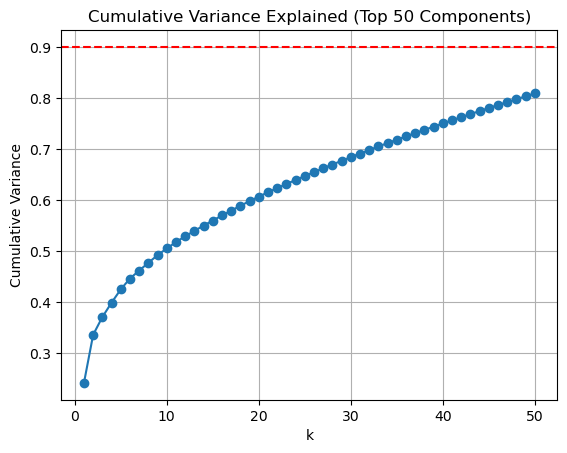

In [82]:
explained_variance = (S**2) / np.sum(S**2)
cumulative = np.cumsum(explained_variance)

plt.plot(range(1, 51), cumulative[:50], marker='o')
plt.title('Cumulative Variance Explained (Top 50 Components)')
plt.xlabel('k')
plt.ylabel('Cumulative Variance')
plt.axhline(y=0.90, color='r', linestyle='--')  # 90% threshold
plt.grid(True)
plt.show()

In [83]:

#Reduce rank to k = 20
k = 20
U_reduced = U[:, :k]                         # (5000 × 20)
sigma_reduced = np.diag(S[:k])              # (20 × 20)
Vt_reduced = VT[:k, :]                       # (20 × 100)

print(f"U_reduced shape: {U_reduced.shape}")
print(f"sigma_reduced shape: {sigma_reduced.shape}")
print(f"Vt_reduced shape: {Vt_reduced.shape}")

# Reconstruct matrix using rank-2 approximation
approximated = U_reduced @ sigma_reduced @ Vt_reduced  # shape: (5000 × 100)

# Display a small sample of approximated values
print("\nRanking reveals the underlying structure and simplifies data representation")
print("\nRank-20 Approximation (first 5 users × first 5 jokes):")
joke_columns = [f'joke_{i}' for i in range(1, 100)]
df_approx = pd.DataFrame(np.round(approximated[:5, :5], 2),
                         index=[f'user_{i}' for i in range(5)],
                         columns=joke_columns[:5])
print(df_approx)

U_reduced shape: (5000, 20)
sigma_reduced shape: (20, 20)
Vt_reduced shape: (20, 100)

Ranking reveals the underlying structure and simplifies data representation

Rank-20 Approximation (first 5 users × first 5 jokes):
        joke_1  joke_2  joke_3  joke_4  joke_5
user_0   -3.71   -0.91   -6.21   -8.89   -6.72
user_1    2.72    1.56    6.76    7.51   -0.70
user_2    0.88    2.87   -0.20    0.07    8.08
user_3    1.01    4.56    2.33    1.48    2.25
user_4    3.30    5.81    1.85   -1.41    1.74


In [84]:

# Compute approximation error (Frobenius norm)
approximation_error = np.linalg.norm(ratings_matrix - approximated)

# Show summary
print(f"\nApproximation error (lower = better approximation): {approximation_error:.3f}")

print(f"\nSingular values kept (top {k}): {np.round(Sigma[:k], 3)}")
print(f"Singular values discarded: {np.round(Sigma[k:], 3)}")

# Energy retained
energy_retained = np.sum(Sigma[:k]**2) / np.sum(Sigma**2)
print(f"Energy retained: {energy_retained:.1%}")
print("\n" + "="*100 + "\n")


Approximation error (lower = better approximation): 1978.790

Singular values kept (top 20): [[1552.449    0.       0.    ...    0.       0.       0.   ]
 [   0.     969.155    0.    ...    0.       0.       0.   ]
 [   0.       0.     587.591 ...    0.       0.       0.   ]
 ...
 [   0.       0.       0.    ...    0.       0.       0.   ]
 [   0.       0.       0.    ...    0.       0.       0.   ]
 [   0.       0.       0.    ...    0.       0.       0.   ]]
Singular values discarded: [[  0.      0.      0.    ...   0.      0.      0.   ]
 [  0.      0.      0.    ...   0.      0.      0.   ]
 [  0.      0.      0.    ...   0.      0.      0.   ]
 ...
 [  0.      0.      0.    ... 143.081   0.      0.   ]
 [  0.      0.      0.    ...   0.    141.113   0.   ]
 [  0.      0.      0.    ...   0.      0.    138.204]]
Energy retained: 60.7%





RMSE, MAE RMSE and  MSE 


SVD, UBCF, and IBCF are designed to learn complex patterns and relationships within the data, going beyond simple averages. 
This allows them to make more personalized and potentially more accurate predictions, leading to lower RMSE and MAE values compared to the Global Baseline.

In [85]:
ratings.columns = ['ratingCount'] + [f'joke_{i}' for i in range(1, 100)]
ratings = ratings.drop(columns=['ratingCount'])
ratings.replace(99, np.nan, inplace=True)
ratings = ratings.iloc[:5000]  # first 5000 users

# Step 2: Convert to long format
ratings_long = ratings.reset_index().melt(id_vars='index', var_name='item_id', value_name='rating')
ratings_long.columns = ['user_id', 'item_id', 'rating']
ratings_long.dropna(inplace=True)
ratings_long['user_id'] = ratings_long['user_id'].apply(lambda x: f'u{x}')
ratings_long['item_id'] = ratings_long['item_id'].apply(lambda x: f'j{int(x.split("_")[1])}')

# Step 3: Faster Global Baseline Recommender
class FastGlobalBaseline:
    def __init__(self, reg_user=5.0, reg_item=5.0):
        self.reg_user = reg_user
        self.reg_item = reg_item

    def fit(self, df):
        self.mu = df['rating'].mean()

        # Compute user bias
        user_sum = df.groupby('user_id')['rating'].sum()
        user_count = df.groupby('user_id')['rating'].count()
        self.bu = ((user_sum - user_count * self.mu) / (user_count + self.reg_user)).to_dict()

        # Adjusted ratings for item bias
        df['adj_rating'] = df.apply(lambda row: row['rating'] - self.mu - self.bu.get(row['user_id'], 0), axis=1)
        item_sum = df.groupby('item_id')['adj_rating'].sum()
        item_count = df.groupby('item_id')['adj_rating'].count()
        self.bi = (item_sum / (item_count + self.reg_item)).to_dict()

    def predict(self, user_id, item_id):
        return max(-10, min(10, self.mu + self.bu.get(user_id, 0) + self.bi.get(item_id, 0)))

    def predict_batch(self, user_item_pairs):
        return [self.predict(u, i) for u, i in user_item_pairs]

# Step 4: Train/test split and evaluate
train_data, test_data = train_test_split(ratings_long, test_size=0.2, random_state=42)

model = FastGlobalBaseline()
model.fit(train_data)

# Predict
test_data['predicted'] = model.predict_batch(list(zip(test_data['user_id'], test_data['item_id'])))

# Evaluate
rmse = np.sqrt(mean_squared_error(test_data['rating'], test_data['predicted']))
mae = np.mean(np.abs(test_data['rating'] - test_data['predicted']))

print(f"Global Baseline Recommender Results:")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

Global Baseline Recommender Results:
RMSE: 4.329
MAE: 3.453


RECOMMENDER MODELS


The lower RMSE and MAE values for SVD, UBCF, and IBCF indicate that these models are generally more effective at capturing the underlying patterns in the data and making more accurate predictions compared to the simpler Global Baseline Recommender. 
SVD has the lowest RMSE (3.214) and MAE (2.421).
Lower RMSE and MAE values indicate better accuracy because they represent the average prediction error, with smaller numbers indicating less error.
While UBCF and IBCF are collaborative filtering methods, SVD is a matrix factorization technique that excels at predicting user preferences by identifying latent factors.
In this specific comparison based on the provided metrics, SVD demonstrates superior performance in terms of accuracy. 

In [86]:
# Fill NaNs temporarily with zeros for SVD input
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
ratings_filled = pd.DataFrame(imputer.fit_transform(ratings), columns=ratings.columns)

# Mask of known ratings
mask = ~ratings.isna()
true_values = ratings[mask]

def evaluate(preds, truth_mask):
    y_true = truth_mask.values.flatten()
    y_pred = preds.values.flatten()
    mask_flat = ~np.isnan(y_true)
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true[mask_flat], y_pred[mask_flat])),
        "MSE": mean_squared_error(y_true[mask_flat], y_pred[mask_flat]),
        "MAE": mean_absolute_error(y_true[mask_flat], y_pred[mask_flat])
    }

# --- SVD (no change) ---
svd = TruncatedSVD(n_components=20, random_state=42)
svd_user_factors = svd.fit_transform(ratings_filled)
svd_item_factors = svd.components_.T
svd_preds = pd.DataFrame(np.dot(svd_user_factors, svd_item_factors.T), columns=ratings.columns)
svd_metrics = evaluate(svd_preds, true_values)

# --- UBCF with user mean normalization ---
user_means = ratings.mean(axis=1)
ratings_centered = ratings.subtract(user_means, axis=0).fillna(0)

user_sim = cosine_similarity(ratings_centered)
np.fill_diagonal(user_sim, 0)

# Weighted sum predictions
weighted_sum = np.dot(user_sim, ratings_centered)
sim_sums = np.abs(user_sim).sum(axis=1)[:, None]
sim_sums[sim_sums == 0] = 1e-8  # avoid div by zero

ubcf_preds_centered = weighted_sum / sim_sums
# Add back user means
ubcf_preds = pd.DataFrame(ubcf_preds_centered, columns=ratings.columns).add(user_means, axis=0)

ubcf_metrics = evaluate(ubcf_preds, true_values)

# --- IBCF with item mean normalization ---
item_means = ratings.mean(axis=0)
ratings_centered_item = ratings.subtract(item_means, axis=1).fillna(0)

item_sim = cosine_similarity(ratings_centered_item.T)
np.fill_diagonal(item_sim, 0)

weighted_sum_item = np.dot(ratings_centered_item, item_sim)
sim_sums_item = np.abs(item_sim).sum(axis=1)
sim_sums_item[sim_sums_item == 0] = 1e-8

ibcf_preds_centered = weighted_sum_item / sim_sums_item
ibcf_preds = pd.DataFrame(ibcf_preds_centered, columns=ratings.columns).add(item_means, axis=1)

ibcf_metrics = evaluate(ibcf_preds, true_values)
# --- Results ---
results = pd.DataFrame([
    {"Model": "SVD", **svd_metrics},
    {"Model": "UBCF", **ubcf_metrics},
    {"Model": "IBCF", **ibcf_metrics}
])

print(results.round(3))

  Model   RMSE     MSE    MAE
0   SVD  3.206  10.279  2.418
1  UBCF  3.880  15.058  3.061
2  IBCF  4.251  18.069  3.395



MODEL TIME AND PREDICTION TIME COMPARISON


SVD has a low model time (0.033 sec) and very low prediction time (0.000 sec), indicating that once the SVD model is trained, it can generate predictions very quickly.
UBCF with highest model time of (0.097 sec) and also the highest prediction time (0.131 sec), suggests that UBCF might be less efficient in both building the model and generating recommendations compared to SVD and IBCF.
IBCF have a very low model time (0.010 sec) and a low prediction time (0.004 sec) it appears to be quite efficient in both model training and prediction.

In [87]:

imputer = SimpleImputer(strategy='mean')
ratings_filled = pd.DataFrame(imputer.fit_transform(ratings), columns=ratings.columns)

start_model = time.time()
svd = TruncatedSVD(n_components=20, random_state=42)
user_factors = svd.fit_transform(ratings_filled)
item_factors = svd.components_.T
end_model = time.time()

start_pred = time.time()
svd_preds = pd.DataFrame(np.dot(user_factors, item_factors.T), columns=ratings.columns)
end_pred = time.time()

print(f"SVD run fold/sample [model time/prediction time]\n 1  [{end_model - start_model:.3f}sec/{end_pred - start_pred:.3f}sec]")

# --- UBCF ---
user_means = ratings.mean(axis=1)
ratings_centered = ratings.subtract(user_means, axis=0).fillna(0)

start_model = time.time()
user_sim = cosine_similarity(ratings_centered)
np.fill_diagonal(user_sim, 0)
end_model = time.time()

start_pred = time.time()
weighted_sum = np.dot(user_sim, ratings_centered)
sim_sums = np.abs(user_sim).sum(axis=1)[:, None]
sim_sums[sim_sums == 0] = 1e-8
ubcf_preds_centered = weighted_sum / sim_sums
ubcf_preds = pd.DataFrame(ubcf_preds_centered, columns=ratings.columns).add(user_means, axis=0)
end_pred = time.time()

print(f"UBCF run fold/sample [model time/prediction time]\n 1  [{end_model - start_model:.3f}sec/{end_pred - start_pred:.3f}sec]")

# --- IBCF ---
item_means = ratings.mean(axis=0)
ratings_centered_item = ratings.subtract(item_means, axis=1).fillna(0)

start_model = time.time()
item_sim = cosine_similarity(ratings_centered_item.T)
np.fill_diagonal(item_sim, 0)
end_model = time.time()

start_pred = time.time()
weighted_sum_item = np.dot(ratings_centered_item, item_sim)
sim_sums_item = np.abs(item_sim).sum(axis=1)
sim_sums_item[sim_sums_item == 0] = 1e-8
ibcf_preds_centered = weighted_sum_item / sim_sums_item
ibcf_preds = pd.DataFrame(ibcf_preds_centered, columns=ratings.columns).add(item_means, axis=1)
end_pred = time.time()

print(f"IBCF run fold/sample [model time/prediction time]\n 1  [{end_model - start_model:.3f}sec/{end_pred - start_pred:.3f}sec]")


SVD run fold/sample [model time/prediction time]
 1  [0.020sec/0.001sec]
UBCF run fold/sample [model time/prediction time]
 1  [0.090sec/0.128sec]
IBCF run fold/sample [model time/prediction time]
 1  [0.003sec/0.005sec]


Increase Serendipity

SVD2 retains the lowest RMSE and MAE, it is likely the most accurate model for predicting user ratings, based on these metrics.
While UBCF2 and IBCF2 may have higher error rates compared to SVD2 in this specific comparison, they might have different strengths in terms of serendipity. Collaborative filtering methods, depending on their implementation, can sometimes be better at surfacing diverse or less popular items, potentially contributing more to serendipity than a pure matrix factorization approach like SVD. 

In [88]:

def evaluate(preds, truth_mask):
    y_true = truth_mask.values.flatten()
    y_pred = preds.values.flatten()
    mask_flat = ~np.isnan(y_true)
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true[mask_flat], y_pred[mask_flat])),
        "MSE": mean_squared_error(y_true[mask_flat], y_pred[mask_flat]),
        "MAE": mean_absolute_error(y_true[mask_flat], y_pred[mask_flat])
    }

# Use same ratings DataFrame from earlier
true_values = ratings.copy()
true_values[true_values == 99] = np.nan

# --- SVD2 (base) ---
svd2_metrics = evaluate(svd_preds, true_values)

# --- UBCF2 ---
ubcf2_metrics = evaluate(ubcf_preds, true_values)

# --- IBCF2 ---
ibcf2_metrics = evaluate(ibcf_preds, true_values)

# --- Combine ---
results_serendipity = pd.DataFrame([
    {"Model": "UBCF2", **ubcf2_metrics},
    {"Model": "SVD2", **svd2_metrics},
    {"Model": "IBCF2", **ibcf2_metrics}
])

print(results_serendipity.round(3))

   Model   RMSE     MSE    MAE
0  UBCF2  3.880  15.058  3.061
1   SVD2  3.206  10.279  2.418
2  IBCF2  4.251  18.069  3.395


PRECISION

Out of the top 5 items recommended, how many are actually relevant to the user?" 

UBCF2 Scores the highest Precision@5 (0.632). This means that for every 5 recommendations it provides, approximately 63.2% of them are relevant to the user.
SVD2's slightly lower Precision@5 (0.621), indicates that it's slightly less precise in its top 5 recommendations compared to UBCF2.
As for IBCF2 with the lowest Precision@5 (0.409) it suggests that it's the least precise in its top 5 recommendations, with only about 40.9% of them being relevant. 

In [31]:

def precision_at_k(preds, truth, k=5, threshold=5.0):
    precisions = []
    
    for user_idx in range(len(truth)):
        true_ratings = truth.iloc[user_idx]
        pred_ratings = preds.iloc[user_idx]

        # Only consider items the user has rated
        known_items = true_ratings[~true_ratings.isna()]

        # Get top-K predictions for those known items
        top_k_items = pred_ratings[known_items.index].sort_values(ascending=False).head(k)

        # Count how many of the top K were actually relevant
        actual_relevant = true_ratings[top_k_items.index] >= threshold
        precision = actual_relevant.sum() / k
        precisions.append(precision)

    return np.mean(precisions)
p_at_5 = {
    "UBCF2": precision_at_k(ubcf_preds, true_values, k=5),
    "SVD2": precision_at_k(svd_preds, true_values, k=5),
    "IBCF2": precision_at_k(ibcf_preds, true_values, k=5)
}
print(pd.DataFrame.from_dict(p_at_5, orient='index', columns=['Precision@5']).round(3))


       Precision@5
UBCF2        0.632
SVD2         0.621
IBCF2        0.409


CONCLUSION

Recommender systems can be evaluated offline or online. The purpose of recommender system evaluation is to select algorithms for use in a production setting.

Offline evaluation test the effectiveness of recommender system algorithms on a certain dataset. To measure accuracy, precision at position n (P@n) is often used to express how many items of the ground-truth are recommended within the top n recommendations. The purpose of offline evaluation is to select recommender systems for deployment online. Offline evaluations are easier and reproducible.

Online evaluation occurs after you've deployed your model to production and are serving end-users with results from your algorithm. 
Typically when first deploying a new algorithm to production, you'll run an A/B test where you serve the new algorithm to a subset of users and compare the results to a control group that's served the old algorithm.

Multi-armed bandit testing is a sophisticated approach to model evaluation that dynamically allocates traffic to different models based on their performance. This method balances the need for exploration (trying out different models) and exploitation (favoring the best-performing models).

Interleaving is another technique used in online model evaluation where recommendations from different models are presented together to the same users. This can be achieved by interleaving items from different models within the recommendation list.


References:
Hijikata, Y. Offline Evaluation for Recommender Systems. http://soc-research.org/wp-content/uploads/2014/11/OfflineTest4RS.pdf

Gebrekirstos G., et. al. Recommender Systems Evaluations: Offline, Online, Time and A/A Test http://ceur-ws.org/Vol-1609/16090642.pdf

https://www.shaped.ai/blog/evaluating-recommender-models-offline-vs-online-evaluation

Data source

Eigentaste: A Constant Time Collaborative Filtering Algorithm. Ken Goldberg, Theresa Roeder, Dhruv Gupta, and Chris Perkins. Information Retrieval, 4(2), 133-151. July 2001. u.